# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

## Section 1
In this section we import data from wikipedia into a dataframe and clean the data

In [1]:
import pandas as pd
import io
import requests
import numpy as np
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
load_df=pd.read_html(url)
canada_df = load_df[0]

In [2]:
#Comments include the requirements for the assignment
#The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
canada_df.head() #for the initial column check

#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
canada_df = canada_df[canada_df['Borough'] != 'Not assigned']

#clean up the dataframe and fix a column name
canada_df.reset_index(inplace = True)
canada_df.drop(columns = ['index'], inplace = True)
canada_df.rename(columns = {'Postal code':'PostalCode'})

#More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, 
#you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows 
#will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

#seems there were already combined but separated by a slash. Changed to a period.
canada_df = canada_df.replace(' / ', ', ', regex=True)

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

#Didn't find any evidence of this, but wrote the code JIC
canada_df['Neighborhood'][canada_df['Neighborhood'] == 'Not Assigned'] = canada_df['Borough'] 

#Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making

#In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.
canada_df.shape

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(103, 3)

In [3]:
#Here's the findal data frame for section 1
canada_df

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Business reply mail Processing CentrE
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


# Section 2
### In this section we add geocoordinates to our dataframe.

#### The geocoder is not working because the geocoder.google function returns an 'unauthorized' error.
You can ignore this first block of code, as we're using the csv in the section underneath.

### Here's the real code

In [5]:
#load the csv with coordinates for this exercise
csv = '~/ML/ds_capstone_project/Geospatial_Coordinates.csv'
lat_lng_df=pd.read_csv(csv)
lat_lng_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
#update the coordinates
#np.where(canada_df.Postal/ code.eq(postal_code), lat_lng_df.latitude, latitude)

canada_df = canada_df.set_index('Postal code').join(lat_lng_df.set_index('Postal Code'))
canada_df.reset_index(inplace = True) #puts the Postal code back as a column and adds a new index
canada_df.rename(columns = {'Postal code': 'PostalCode'}, inplace = True)
canada_df.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Section 3

In this section we "explore & cluster" the data.

#### Boroughs vs Neighborhoods
My curiosity is to see if we do a stright kmeans cluster on the neighborhoods, do we get the data grouped by boroughs or does the cluster create a new "meta-entity" that is not the same as the borough. Kmeans will only use the lat-long coordinates and not the boroughs names. 

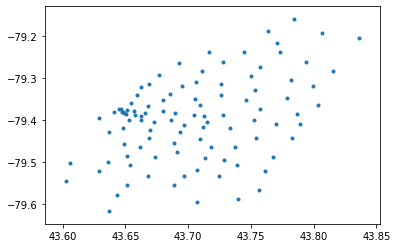

In [7]:
#let's see how the neighborhoods look without a map
plt.scatter(canada_df['Latitude'], canada_df['Longitude'], marker='.')

### Not a lot of obvious clusters in the scatterplot for kmeans

In [8]:
#let's see how many burroughs we are trying to re-create
ks = len(canada_df['Borough'].unique())
print ('We are creating {} boroughs.'.format(ks))

We are creating 10 boroughs.


In [9]:
#let's get to clustering

k_means = KMeans(n_clusters = ks) #sets the number of clusters
k_means.fit(canada_df[['Latitude','Longitude']]) #runs the clustering
k_means_labels = k_means.labels_ #put the labels in an array

canada_df['cluster'] = k_means_labels #add the labels to the dataframe

#let's see show the clusters are shaping up
canada_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,cluster
0,M3A,North York,Parkwoods,43.753259,-79.329656,7
1,M4A,North York,Victoria Village,43.725882,-79.315572,4
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,8
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8


In [10]:
#let's see how well the boroughs and clusters are grouped
borough_df = canada_df[['Borough','cluster']].groupby(by = 'Borough').nunique()
borough_df.drop(columns=['Borough'], inplace = True)
borough_df.rename(columns={'cluster':'cluster_count'}, inplace = True)
borough_df.reset_index(inplace = True) #puts the Borough code back as a column and adds a new index
borough_df.sort_values(by=['cluster_count'], ascending = False)

#the dataframe below shows how many different clusters are used in each existing boroughs

,Borough,cluster_count
6,North York,5
4,Etobicoke,3
7,Scarborough,3
8,West Toronto,3
9,York,3
0,Central Toronto,2
1,Downtown Toronto,2
2,East Toronto,1
3,East York,1
5,Mississauga,1


In [11]:
#Unsuprisingly, the clusters do not match exactly with the boroughs as many/most boroughs contain more than one cluster.

#Let's see how they look on a map.
#We can use the borough dataframe index to represent a cluster number 

canada_df['BoroughNum'] = ''

for i in range(canada_df.shape[0]):
    canada_df['BoroughNum'][i] = borough_df[borough_df['Borough'] == canada_df['Borough'][i]].index[0]

#here you can see the BoroughNum (or ID) is set for each Neighborhood
canada_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,PostalCode,Borough,Neighborhood,Latitude,Longitude,cluster,BoroughNum
0,M3A,North York,Parkwoods,43.753259,-79.329656,7,6
1,M4A,North York,Victoria Village,43.725882,-79.315572,4,6
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,8,1
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,6
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8,1
...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,5,4
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8,1
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558,4,2
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,5,4


# MAP!
For the map we use markers to designate both the original borough (the inside color) juxtaposed with the new neighborhood cluster (the outside color).

Groups of markers with a similar color pattern show where the borough and cluster are similar and start to diverge when the outside color changes (designating a new cluster). 

In [12]:
#Toronto 'center' for the starting map position
latitude = 43.6962
longitude = -79.3832

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
colors_array = cm.rainbow(np.linspace(0, 1, ks))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to map
for lat, lng, borough, cluster, bnum in zip(canada_df['Latitude'], canada_df['Longitude'], canada_df['Borough'], canada_df['cluster'], canada_df['BoroughNum']):
    label = '{}- {}'.format(cluster, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[bnum],
        fill_opacity=1,
        parse_html=False).add_to(map_toronto)

# let's see the map
map_toronto

# Thanks for reviewing!